In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #생성되는 이미지를 관찰하기 위함입니다. 3차원 플롯을 그리는 용도입니다.
from matplotlib import cm # 데이터포인트에 색상을 입히는 것에 사용됩니다.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # gpu('cuda')가 사용가능하면, gpu를 이용하도록 설정
device

device(type='cuda')

# FashionMNIST 데이터 전처리
* 사용할 데이터 : FashionMNIST

### 데이터 전처리 및 사전 작업

In [3]:
# 데이터 전처리

my_transform = transforms.Compose([transforms.ToTensor(), # tensor로 펴준다.
                                      transforms.Normalize((0.5,),(0.5,))]) # 정규화를 해준다.

In [4]:
# FashionMNIST 데이터 다운로드 및 전처리 transform 적용

trainset = datasets.FashionMNIST(root='/content',
                                 train=True, download=True,
                                 transform=my_transform)

testset = datasets.FashionMNIST(root='/content',
                                 train=False, download=True,
                                 transform=my_transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [5]:
# batch 만큼 나눠서 담기; mini-batch GD를 위함

train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

test_loader = DataLoader(trainset, batch_size=64, shuffle=False, num_workers=2)

In [6]:
# 다음 함수를 통해 DataLoader()안의 값을 확인할 수 있다.

dataiter = iter(train_loader) # 1개만 확인해보자
images, labels = next(dataiter) # A.E.는 unsupervised-learning임으로 사실 labels값은 필요가 없다.
images.shape, labels.shape # tensor의 형태이다.

# 추가 정보
# 사진의 크기 28x28, 칼라(3), 사진 갯수 64개

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [7]:
# 숫자 label에 해당되는 값

labels_map = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

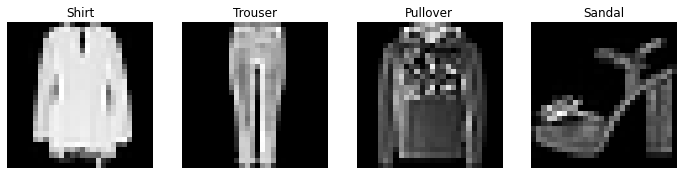

In [8]:
# 데이터 확인

figure = plt.figure(figsize=(12,12))
cols, rows = 4, 1

for i in range(1, cols * rows + 1):
    image = images[i].squeeze()
    label_idx = labels[i].item() # y_label
    label = labels_map[label_idx] # 위에서 해당되는 label

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(image, cmap='gray')

plt.show()

# Auto-Encoder(=D.A.E.) & Denoising Auto-Encoder(=D.A.E.)

* 사용할 데이터 FashionMNIST
* 사용할 모델 : 기본적인 A.E. & D.A.E.
> - conv-layer로만 구성된 모델

* 학습 후
> - manifold-learning
> - generative-model

## 기본적인 A.E. 모델 학습 및 평가
* Convolution-layer만을 사용한 A.E.
* AE_Conv

In [10]:
class AE_Conv(nn.Module):

    # 1. 변수선언
    def __init__(self):
        super(AE_Conv, self).__init__()

        # 1-1. Encoder Neural-Net 부분
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # (64, 1, 28, 28) -> (64, 16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # (64, 16, 14, 14) -> (64, 32, 7, 7)
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # (64, 32, 7, 7) -> (64, 64, 1, 1) # 64길이의 latent-vector
        )
        
        # 1-2. Decoder Neural-Net 부분;
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # (64, 64, 1, 1) -> (64, 32, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # (64, 32, 7, 7) -> (64, 16, 14, 14); (8,16,13,13 if without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # (64, 16, 14, 14) -> (64, 1, 28, 28) # encoder의 input-data size와 같아졌다.
            nn.Sigmoid()
        )


    # 2. 함수선언
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
model_AE = AE_Conv().to(device) # gpu에 모델 업로드

In [12]:
# 손실함수와 옵티마이저

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model_AE.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5) # 가중치들의 합을 규제하여, 과적합을 막는다.

In [14]:
# 모델 학습; train데이터 이용
# 이전과 달리 unsupervised이나, input-data가 label로 작용하기에
# 기존의 0~9의 labels이 아닌 input-data(28x28 image)를 label로 사용해야한다.

num_epochs = 4
output_list = []

# epoch 마다
for epoch in range(num_epochs):
    # batch 마다
    for i, data in enumerate(train_loader, 0):
        images, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

        X = images
        outputs = model_AE(X) # y_pred = f(X)
        X_hat = outputs
        loss = criterion(X_hat, X)

        loss.backward() # back-propagation; gradient 계산
        optimizer.step() # parameters(weights) update

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    output_list.append((epoch, X, X_hat))

Epoch:1, Loss:0.6358
Epoch:2, Loss:0.6126
Epoch:3, Loss:0.5751
Epoch:4, Loss:0.5755


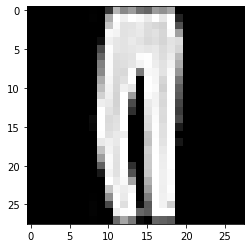

In [15]:
# input-data; X

npimg = X[0].detach().to('cpu').numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), cmap='gray') # (C,H,W) -> (H,W,C)로 바꿔주는 작업
plt.show()

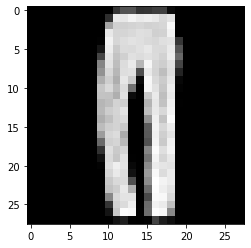

In [16]:
# output-data; X_hat

npimg = X_hat[0].detach().to('cpu').numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), cmap='gray')
plt.show()

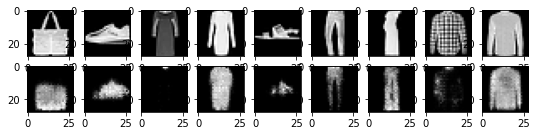

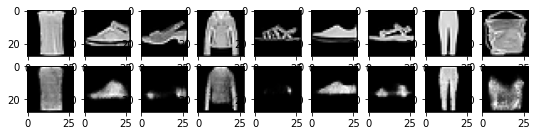

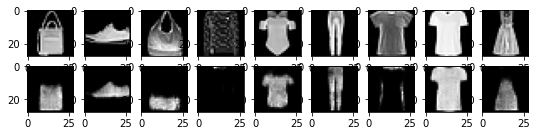

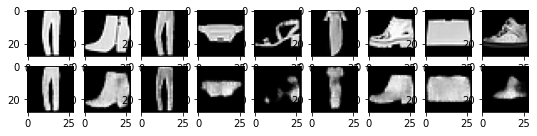

In [17]:
# train데이터에 대한 모델 학습 결과 확인; 시각화

for k in range(0, num_epochs):

    plt.figure(figsize=(9, 2*num_epochs))
    plt.gray()

    imgs = output_list[k][1].detach().to('cpu').numpy()
    recon = output_list[k][2].detach().to('cpu').numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2*num_epochs, 9, i+1)
        plt.imshow(item[0], cmap='gray')
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2*num_epochs, 9, 9+i+1) 
        plt.imshow(item[0], cmap='gray')

In [18]:
# 모델 평가; test데이터 이용

correct = 0
output_list = []

with torch.no_grad(): # grad가 필요없다.
    for i, data in enumerate(test_loader, 0):
        images, labels = data[0].to(device), data[1].to(device)

        X = images
        outputs = model_AE(X) # y_pred = f(X)
        X_hat = outputs

        output_list.append((epoch, X, X_hat))

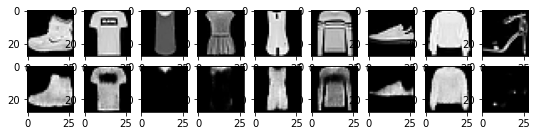

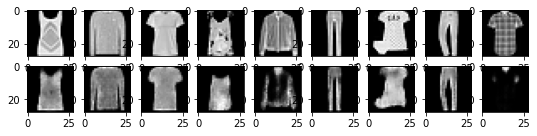

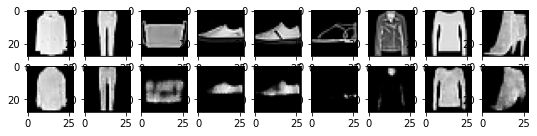

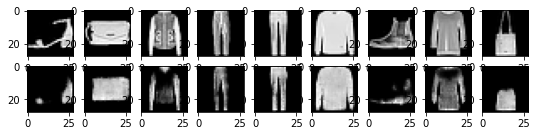

In [19]:
# test데이터에 대한 모델 학습 결과 확인; 시각화

for k in range(0, num_epochs):

    plt.figure(figsize=(9, 2*num_epochs))
    plt.gray()

    imgs = output_list[k][1].detach().to('cpu').numpy()
    recon = output_list[k][2].detach().to('cpu').numpy()
    
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2*num_epochs, 9, i+1)
        plt.imshow(item[0], cmap='gray')
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2*num_epochs, 9, 9+i+1)
        plt.imshow(item[0], cmap='gray')

## Denosing A.E. 모델 학습 및 평가
* Noise를 추가한 A.E.
* Convolution-layer만을 이용한 D.A.E.
* DAE_Conv

In [20]:
# 잡음 더하기
def add_noise(img, rate=0.2):
    noise = torch.randn(img.size()) * rate
    noise = noise.to(device)
    noisy_img = img + noise
    return noisy_img

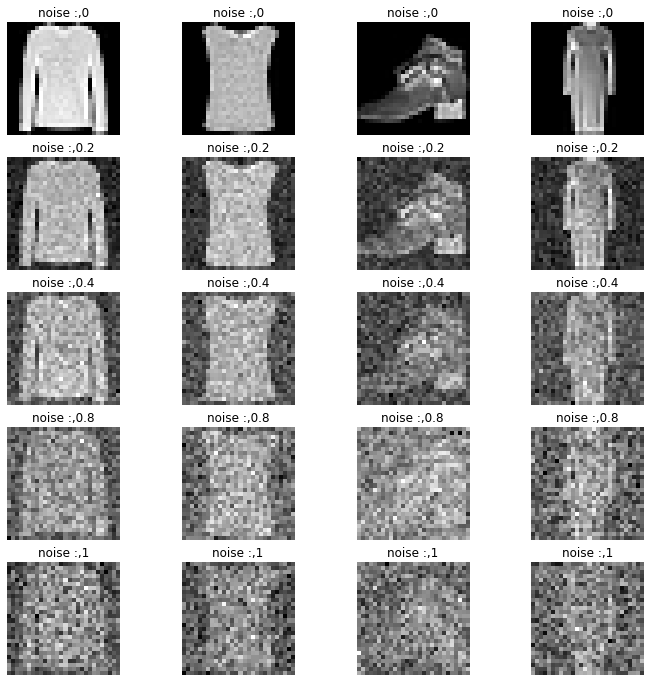

In [21]:
# 잡음 데이터 확인

figure = plt.figure(figsize=(12,12))

noise_rate_list = [0, 0.2, 0.4, 0.8, 1]

for k in range(len(noise_rate_list)): # k=0~4

    for i in range(4): # i=0~3
        image = images[i].squeeze()
        image = add_noise(image, noise_rate_list[k]) # X_image with noise
        label_idx = labels[i].item() # y_label
        label = labels_map[label_idx] # 위에서 해당되는 label

        plt.subplot(5,4,k*4+i+1)
        plt.title('noise :,' + str(noise_rate_list[k]))
        plt.axis('off')
        plt.imshow(image.to('cpu'), cmap='gray')

plt.show()

# 0.2나 0.4가 적당한 noise같다.

In [22]:
# Convolution-layer만을 이용한 D.A.E. 모델 클래스 선언


class DAE_Conv(nn.Module):

    # 1. 변수선언
    def __init__(self):
        super(DAE_Conv, self).__init__()

        # 1-1. Encoder Neural-Net 부분
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # (64, 1, 28, 28) -> (64, 16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # (64, 16, 14, 14) -> (64, 32, 7, 7)
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # (64, 32, 7, 7) -> (64, 64, 1, 1) # 64길이의 latent-vector
        )
        
        # 1-2. Decoder Neural-Net 부분;
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # (64, 64, 1, 1) -> (64, 32, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # (64, 32, 7, 7) -> (64, 16, 14, 14); (8,16,13,13 if without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # (64, 16, 14, 14) -> (64, 1, 28, 28) # encoder의 input-data size와 같아졌다.
            nn.Sigmoid()
        )

    # 2. 함수선언
    def forward(self, x):
        noisy_x = add_noise(x, rate=0.2) # 이 부분이 달라짐
        encoded = self.encoder(noisy_x) 
        decoded = self.decoder(encoded)
        return decoded


In [23]:
# 모델 객체 선언

model_DAE = DAE_Conv().to(device) # gpu에 모델 업로드

In [24]:
# 손실함수와 옵티마이저

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model_DAE.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5) # 가중치들의 합을 규제하여, 과적합을 막는다.

In [25]:
# 모델 학습; train데이터 이용
# 이전과 달리 unsupervised이나, input-data가 label로 작용하기에
# 기존의 0~9의 labels이 아닌 input-data(28x28 image)를 label로 사용해야한다.

num_epochs = 4
output_list = []

# epoch 마다
for epoch in range(num_epochs):
    # batch 마다
    for i, data in enumerate(train_loader, 0):
        images, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

        X = images
        outputs = model_DAE(X) # y_pred = f(X)
        X_hat = outputs
        loss = criterion(X_hat, X)

        loss.backward() # back-propagation; gradient 계산
        optimizer.step() # parameters(weights) update

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    output_list.append((epoch, X, X_hat))

Epoch:1, Loss:0.6385
Epoch:2, Loss:0.6152
Epoch:3, Loss:0.5629
Epoch:4, Loss:0.5789


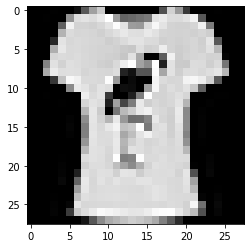

In [26]:
# input-data; X

npimg = X[0].detach().to('cpu').numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), cmap='gray') # (C,H,W) -> (H,W,C)로 바꿔주는 작업
plt.show()

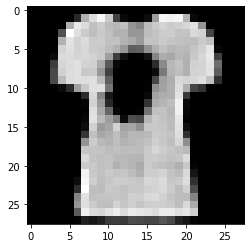

In [27]:
# output-data; X_hat

npimg = X_hat[0].detach().to('cpu').numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), cmap='gray')
plt.show()

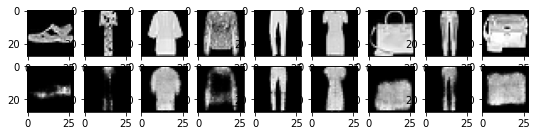

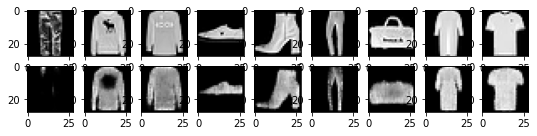

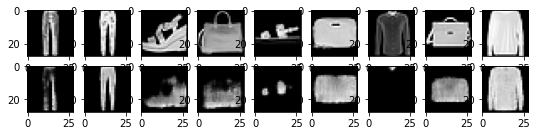

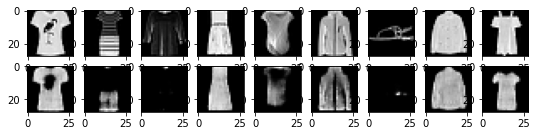

In [28]:
# train데이터에 대한 모델 학습 결과 확인; 시각화

for k in range(0, num_epochs):

    plt.figure(figsize=(9, 2*num_epochs))
    plt.gray()

    imgs = output_list[k][1].detach().to('cpu').numpy()
    recon = output_list[k][2].detach().to('cpu').numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2*num_epochs, 9, i+1)
        plt.imshow(item[0], cmap='gray')
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2*num_epochs, 9, 9+i+1) 
        plt.imshow(item[0], cmap='gray')

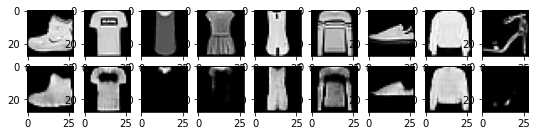

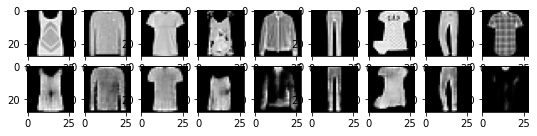

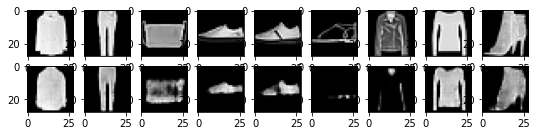

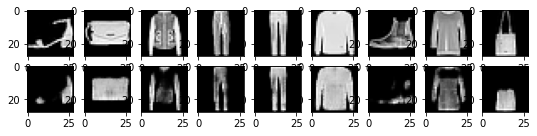

In [29]:
# 모델 평가; test데이터 이용

correct = 0
output_list = []

with torch.no_grad(): # grad가 필요없다.
    for i, data in enumerate(test_loader, 0):
        images, labels = data[0].to(device), data[1].to(device)

        X = images
        outputs = model_DAE(X) # y_pred = f(X)
        X_hat = outputs

        output_list.append((epoch, X, X_hat))

# 시각화
for k in range(0, num_epochs):

    plt.figure(figsize=(9, 2*num_epochs))
    plt.gray()

    imgs = output_list[k][1].detach().to('cpu').numpy()
    recon = output_list[k][2].detach().to('cpu').numpy()
    
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2*num_epochs, 9, i+1)
        plt.imshow(item[0], cmap='gray')
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2*num_epochs, 9, 9+i+1)
        plt.imshow(item[0], cmap='gray')

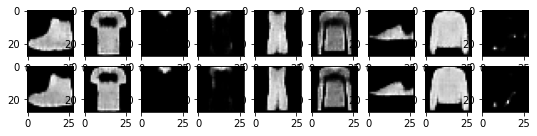

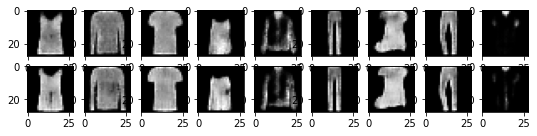

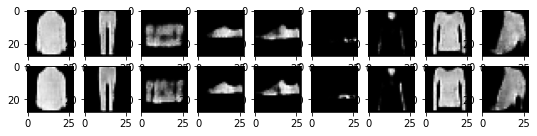

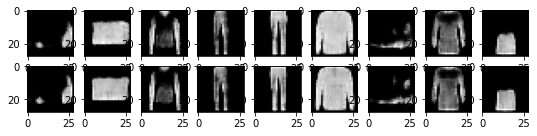

In [30]:
# A.E. & V.A.E 성능 비교

output_list = []

with torch.no_grad(): # grad가 필요없다.
    for i, data in enumerate(test_loader, 0):
        if i==num_epochs: break;
        images, labels = data[0].to(device), data[1].to(device)

        X = images

        output_list.append((epoch, model_AE(X), model_DAE(X)))

# 시각화
for k in range(0, num_epochs):

    plt.figure(figsize=(9, 2*num_epochs))
    plt.gray()

    AE = output_list[k][1].detach().to('cpu').numpy()
    DAE = output_list[k][2].detach().to('cpu').numpy()
    
    for i, item in enumerate(AE):
        if i >= 9: break
        plt.subplot(2*num_epochs, 9, i+1)
        plt.imshow(item[0], cmap='gray')
            
    for i, item in enumerate(DAE):
        if i >= 9: break
        plt.subplot(2*num_epochs, 9, 9+i+1)
        plt.imshow(item[0], cmap='gray')


# 결과
# 첫번째 줄이 AE결과이며, 두번째 줄이 DAE결과이다.
# 이게 num_epochs 수만큼 반복되는데, AE와 DAE의 성능이 거의 비슷하다.

## Encoder를 떼어서 차원축소로 활용
* manifold-learning
* 위에서 학습한 모델인 A.E. & D.A.E. 사용

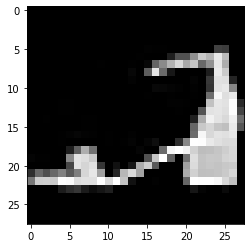

In [31]:
# input-data; images

npimg = X[0].detach().to('cpu').numpy()
plt.imshow(np.transpose(npimg, (1,2,0)))

In [32]:
# output-data; latent-vector

latent_vector1 = model_AE.encoder(X[0]).flatten().detach().to('cpu').numpy()
latent_vector1.shape

(64,)

In [33]:
# output-data; latent-vector

latent_vector2 = model_DAE.encoder(X[0]).flatten().detach().to('cpu').numpy()
latent_vector2.shape

(64,)

## Decoder를 떼어서 생성모델로 활용
* Generative_Model
* 위에서 학습한 모델인 A.E. & D.A.E. 사용

3개의 latent-vector를 가지고 이미지를 Generate해보자.
* (1) 위에서 압축한 latent-vector을 사용해 이미지 Generate
* (2) 0~1의 uniform-Dist에서 뽑은 임의의 latent-vector
* (3) Normal(0.5, 0.5^2)의 Normal-Dist에서 뽑은 임의의 latent-vector

In [34]:
# input-data; latent-vector

latent_vector_list = []

# (1) 위에서 압축한 latent-vector
latent_vector_list.append(latent_vector1)
latent_vector_list.append(latent_vector2)

# (2) 0~1의 uniform-Dist에서 뽑은 임의의 latent-vector
uni_vector = np.random.uniform(0,1,64)
latent_vector_list.append(uni_vector)

# (3) Normal(0.5, 0.5^2)의 Normal-Dist에서 뽑은 임의의 latent-vector
norm_vector = np.random.normal(0.5,0.5, 64)
latent_vector_list.append(norm_vector)

model_AE(위에서 학습시킨 A.E.의 Decoder)와 model_DAE(위에서 학습시킨 D.A.E.의 Decoder)를 사용해 이미지를 생성한 결과를 비교해보자.

In [35]:
# output-data; images

def output_visualize():

    model_list = [model_AE, model_DAE]

    plt.figure(figsize=(24, 16)) 

    for j in range(len(latent_vector_list)):
        for i in range(len(model_list)):
            temp = torch.tensor(latent_vector_list[j], dtype=torch.float).reshape(64,1,1).to(device)
            output_data = model_list[i].decoder(temp)
            
            npimg = output_data.detach().to('cpu').numpy()

            plt.subplot(4,2,j*2+i+1)
            plt.imshow(np.transpose(npimg, (1,2,0)))
        
    plt.show()

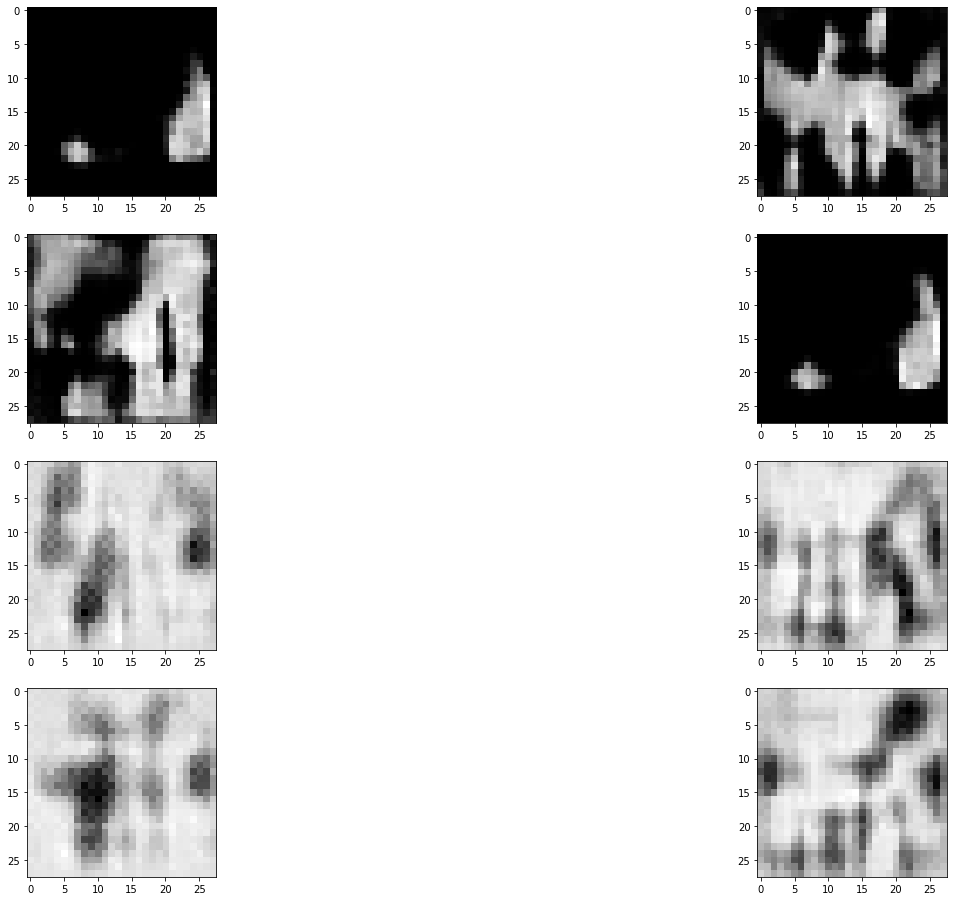

In [36]:
output_visualize()

# 첫번째 행은 A.E.로 만든 latent-vector를 각각 A.E.와 D.A.E.로 다시 이미지생성한 것
# 두번째 행은 D.A.E.로 만든 latent-vector를 각각 A.E.와 D.A.E.로 다시 이미지생성한 것
# 세번째 행은 uniform으로 만든 vector를 각각 A.E.와 D.A.E.로 다시 이미지생성한 것
# 네번째 행은 normal으로 만든 vector를 각각 A.E.와 D.A.E.로 다시 이미지생성한 것

# 그래도 어느 정도 비슷비슷하다.